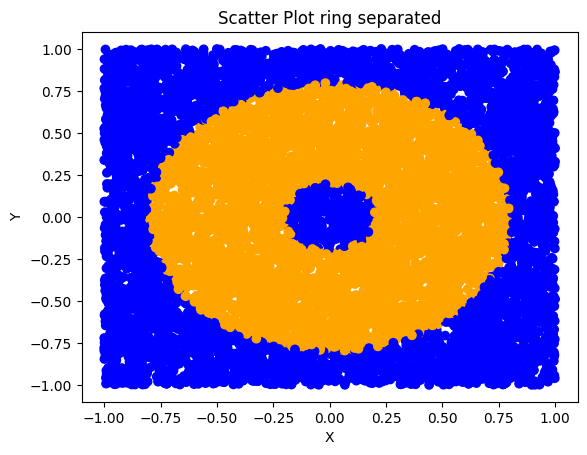

In [12]:
###··· RING MERGED DATASET ···### 
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import heatmap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import numpy as np

# Part 1: Selecting and analyzing the dataset 
# #Load the dataset
ring_separable = pd.read_csv("A2-ring\A2-ring-separable.txt", sep='\t', header=None)
ring_separable.columns = ["X", "Y", "Result"]
# Select the columns
x_train_unscaled = ring_separable[["X", "Y"]]
y_train = ring_separable[["Result"]]

ring_test = pd.read_csv("A2-ring\A2-ring-test.txt", sep='\t', header=None)
ring_test.columns = ["X", "Y", "Result"]
# Select the columns
x_test_unscaled = ring_test[["X", "Y"]]
y_test = ring_test[["Result"]]

# Scale the dat
scaler = MinMaxScaler()
scaler.fit(x_train_unscaled)
x_train = scaler.transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

plt.scatter(x_train_unscaled["X"], x_train_unscaled["Y"], c=y_train["Result"].map({0: 'blue', 1: 'orange'}), marker="o")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot ring separated")
plt.show()

You need to select one of the 2 models (BP or SVM) to generate the grid cross validation function. Then, execute the following script 2.2 to fit the model and generate the prediction:

In [15]:
###---Part 2.a: Implement a tensorflow BP model---#
import tensorflow as tf
from tensorflow import keras as keras
from scikeras.wrappers import KerasClassifier
tf.get_logger().setLevel('ERROR')

# Create the model
model = keras.models.Sequential([
    keras.layers.Dense(5, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
cv_model = KerasClassifier(model=model, verbose=0)
# Perform cross-validation
param_grid = {
    'epochs': [50],
    'optimizer__learning_rate': [0.001, 0.01, 0.1],
    'optimizer__emu_momentum': [0.1, 0.01, 0.001]
}
grid = GridSearchCV(estimator=cv_model,
                    param_grid= param_grid,
                    cv=5, 
                    scoring='accuracy')

In [5]:
###···Part 2.b: Implement MLR ···###
import sklearn.linear_model as lm
# Create the model
model = lm.LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10]
}
# Perform cross-validation
grid = GridSearchCV(estimator=model,
                    param_grid= param_grid,
                    cv=5, 
                    scoring='accuracy')

In [17]:
###···Part 2.c: Implement SVM ···###
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.svm as svm
model = svm.SVC()
# Create the model
param_grid = {
    'C': [0.01, 1, 100, 1000],
    'gamma': [0.1, 1, 10, 'scale'], 
    'kernel': ['rbf']             #RBF (Radial Basis Function) kernel fits is the best option to fit ring shape of the data.
}         
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
grid = GridSearchCV(model, param_grid=param_grid, cv=cv)


Now fit the result and get the predicted values. With predicted values.

In [18]:
#---Part 2.2: Fit the program and obtain results---#
# Fit the model
grid.fit(x_train, y_train.values.ravel())
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Classification error: ", 1 - grid.best_score_)
# Predict the response for test dataset
y_train_pred = grid.predict(x_train)
y_test_pred = grid.predict(x_test)

print("---Train---")
print("Accuracy Score: ", accuracy_score(y_train, y_train_pred))
print("---Test---")
print("Accuracy Score: ", accuracy_score(y_test, y_test_pred))

pd.DataFrame(grid.cv_results_)
pd.DataFrame(grid.cv_results_).to_csv("results_ring_separable_" + model.__class__.__name__+ ".csv")

Best: 0.997300 using {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Classification error:  0.0026999999999999247
---Train---
Accuracy Score:  0.9981
---Test---
Accuracy Score:  0.9961


With predicted values, you can now evaluate the accuracy with confusion matrix, ROC curve and plotting the predicted data with heatmap

[[5312   21]
 [  18 4649]]


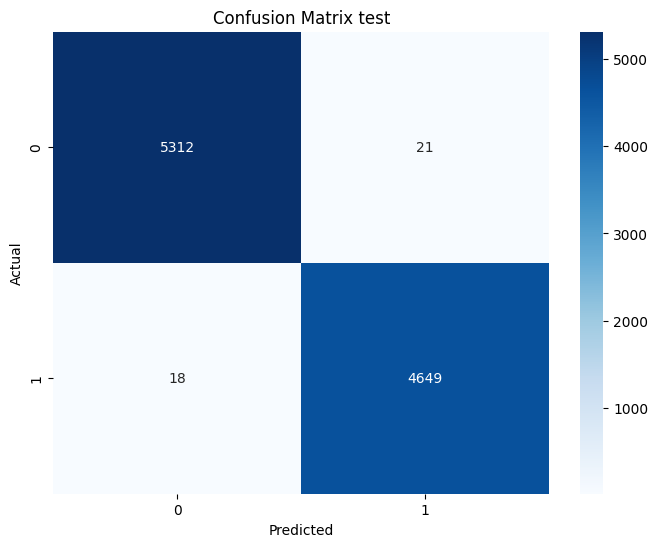

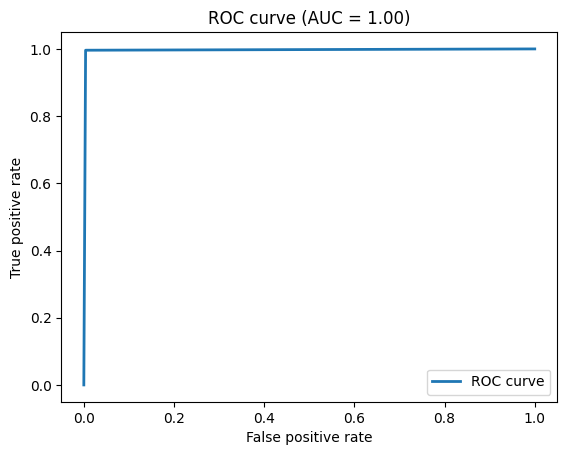

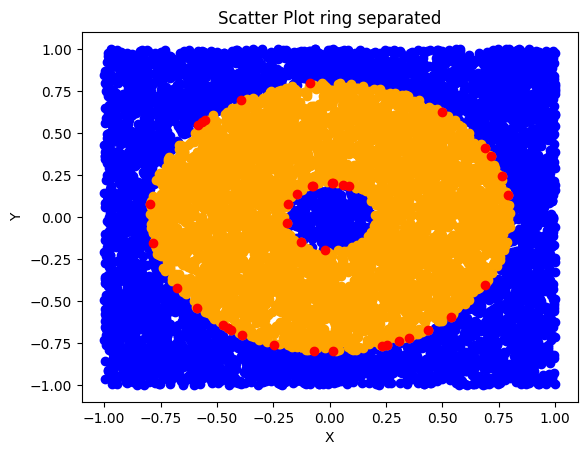

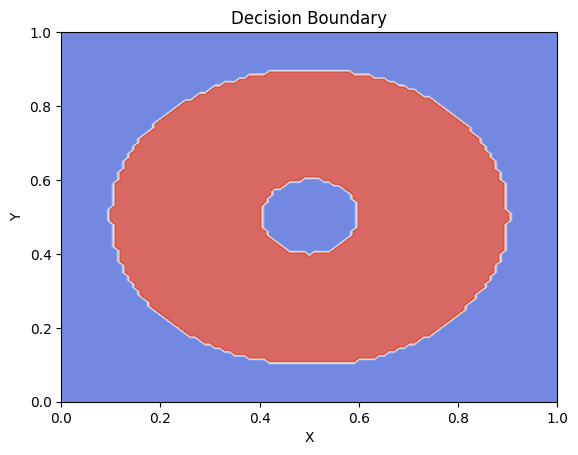

In [19]:
#---Part 3: Evaluate the model and summarize results---#
# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
print(confusion)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix test')
plt.show()

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve + AUC
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, lw=lw, label='ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (AUC = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.show()

# Plot the predicted Data with the missclassified data in red
plt.scatter(x_test_unscaled["X"][y_test_pred == 0], x_test_unscaled["Y"][y_test_pred == 0], c='blue', marker="o")
plt.scatter(x_test_unscaled["X"][y_test_pred == 1], x_test_unscaled["Y"][y_test_pred == 1], c='orange', marker="o")
plt.scatter(x_test_unscaled["X"][y_test_pred != y_test["Result"]], x_test_unscaled["Y"][y_test_pred != y_test["Result"]], c="red", marker="o")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot ring separated")
plt.show()

# Plot the decision boundary
x_min, x_max = x_test_unscaled["X"].min() - 1, x_test_unscaled["X"].max() + 1
y_min, y_max = x_test_unscaled["Y"].min() - 1, x_test_unscaled["Y"].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = grid.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.xlabel("X")
plt.ylabel("Y")
# limit the axis
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Decision Boundary")
plt.show()

